
code to plot DL radar data comparison with rs binned on same RS bins
to reply to reviewer's comment

In [1]:
# importing necessary libraries
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
import numpy as np
import xarray as xr
from datetime import datetime
import matplotlib.dates as mdates
import glob
#from myFunctions import lcl
#from myFunctions import f_closest
from warnings import warn
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import interpolate
import custom_color_palette as ccp
from matplotlib import rcParams
import matplotlib.ticker as ticker
from myFunctions import f_closest

tsg_file = "/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/tsg_sst_data/tsg/nc/msm_089_1_tsg.nc"

DL_data = xr.open_dataset('/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/doppler_lidar/horizontal_wind_direction_msm_eurec4a_campaign.nc')
DL_cold_patch = DL_data.sel(time=slice(datetime(2020,2,2,0,0,0), datetime(2020,2,3,23,59, 59)))

In [13]:
# reading tsg file ( data with 1 min resolution)
tsg_data = xr.open_dataset(tsg_file)

# identifying time stamps of sst corresponding to time stamps of radiosondes
t_start = datetime(2020, 2, 2, 0, 0, 0)
t_end = datetime(2020, 2, 3, 23, 59, 59)

# slicing tsg datase t for the selected time interval and extracting sst
sliced_tsg_ds = tsg_data.sel(TIME=slice(t_start, t_end))
tsg_sst = sliced_tsg_ds['TEMP'].values
tsg_time_sst = sliced_tsg_ds['TIME'].values
tsg_flag = sliced_tsg_ds['TEMP_QC'].values

# averaging together the sst of the different sst sensors for tsg
temp0 = sliced_tsg_ds.TEMP[:,0].values
temp1 = sliced_tsg_ds.TEMP[:,1].values
sst_tsg = temp0
sst_tsg[np.isnan(temp0)] = temp1[np.isnan(temp0)]

# producing output dataset of sst_tsg for the selected time window
# creating dataset with coordinates sst and height
dim_sst           = ['time']
coords            = {"time":sliced_tsg_ds.TIME.values}
SST               = xr.DataArray(dims=dim_sst, coords=coords, data=sst_tsg,
                 attrs={'long_name':'sea surface temperature ',
                        'units':'$^{\circ}$C'})
variables         = {'SST':SST}
SST_DS      = xr.Dataset(data_vars = variables,
                       coords = coords)

# interpolating SST on DL grid
SST_interp = SST_DS.interp(time=DL_cold_patch.time.values)

In [14]:
SST_interp

<xarray.Dataset>
Dimensions:  (time: 1782)
Coordinates:
  * time     (time) datetime64[ns] 2020-02-02T00:01:02.282835 ... 2020-02-03T...
Data variables:
    SST      (time) float64 27.66 27.66 27.65 27.66 ... 26.96 26.95 26.95 26.97

In [18]:
SST_interp.SST.values

array([27.65787862, 27.65774036, 27.65334522, ..., 26.95      ,
       26.9485    , 26.96525   ])

In [15]:
# creating a new dataset with SST as coordinate instead of time
dims = ['sst', 'height']
coords = {'sst':SST_interp.SST.values, 'height':DL_cold_patch.height.values}
H_wind_speed = xr.DataArray(dims=dims, coords=coords, data=DL_cold_patch.H_wind_speed.values)
variables={'H_wind_speed': H_wind_speed}
H_wind_dataset = xr.Dataset(data_vars = variables,
                        coords = coords)
print(H_wind_dataset)

<xarray.Dataset>
Dimensions:       (height: 400, sst: 1782)
Coordinates:
  * sst           (sst) float64 27.66 27.66 27.65 27.66 ... 26.95 26.95 26.97
  * height        (height) float64 0.0 21.21 42.42 ... 8.442e+03 8.463e+03
Data variables:
    H_wind_speed  (sst, height) float64 nan 4.053 7.757 7.977 ... nan nan nan


In [20]:
H_wind_dataset.sst.values

array([27.65787862, 27.65774036, 27.65334522, ..., 26.95      ,
       26.9485    , 26.96525   ])

In [35]:
H_wind_dataset

<xarray.Dataset>
Dimensions:       (height: 400, sst: 1782)
Coordinates:
  * sst           (sst) float64 27.66 27.66 27.65 27.66 ... 26.95 26.95 26.97
  * height        (height) float64 0.0 21.21 42.42 ... 8.442e+03 8.463e+03
Data variables:
    H_wind_speed  (sst, height) float64 nan 4.053 7.757 7.977 ... nan nan nan

In [37]:
h_mean_profile = np.zeros((len(sst_array), len(DL_cold_patch.height.values)))
sst_array = np.asarray([26.2, 26.6, 26.8, 27.1, 27.3, 27.66])
sst_data =  H_wind_dataset.sst.values
print(sst_data)
for ind_sst in range(len(sst_array)-1):
    print(ind_sst)
    # sst extremes
    print()
    check = np.where((sst_array[ind_sst] < sst_data) * (sst_data < sst_array[ind_sst+1]))[0]
    print(len(check))
    print(np.where((sst_array[ind_sst] < sst_data) * (sst_data < sst_array[ind_sst+1]))[0])
    
    # sst array
    #h_wind_sel = H_wind_speed.sel(sst=slice(float(sst_inf),float(sst_sup)))
    h_wind_sel = H_wind_dataset.isel(sst=check)
    print(h_wind_sel)
    #"2000-01-01":"2000-01-02", "IA"]
    # h mean
    h_mean = h_wind_sel.mean(skipna=True, dim='sst')
    h_mean_profile[ind_sst,:] = h_mean.H_wind_speed.values


[27.65787862 27.65774036 27.65334522 ... 26.95       26.9485
 26.96525   ]
0

421
[1007 1008 1009 1010 1011 1012 1013 1014 1015 1016 1017 1018 1019 1020
 1021 1022 1023 1024 1025 1026 1027 1028 1029 1030 1031 1032 1033 1034
 1035 1036 1037 1038 1039 1040 1041 1042 1043 1044 1045 1046 1047 1048
 1049 1050 1051 1052 1053 1054 1055 1056 1057 1058 1059 1060 1061 1062
 1063 1064 1065 1066 1067 1068 1069 1070 1071 1072 1073 1074 1075 1076
 1077 1078 1079 1080 1081 1082 1083 1084 1085 1086 1087 1088 1089 1093
 1094 1095 1096 1097 1098 1099 1100 1101 1102 1103 1104 1105 1106 1107
 1108 1109 1110 1111 1112 1113 1114 1115 1116 1117 1118 1119 1120 1121
 1122 1123 1124 1125 1126 1127 1128 1129 1130 1131 1132 1133 1134 1135
 1136 1137 1138 1139 1140 1141 1142 1143 1144 1145 1146 1147 1148 1149
 1150 1151 1152 1153 1154 1155 1156 1157 1158 1159 1160 1161 1162 1163
 1164 1165 1166 1167 1168 1169 1170 1171 1172 1173 1174 1175 1176 1177
 1238 1239 1240 1241 1242 1243 1244 1245 1246 1247 1248 1249 1250 

In [42]:
# reading radiosonde binned data
path_SST_binned = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/post_processed_data/binned_sst/'

radiosonde_data = xr.open_dataset(path_SST_binned+'RS_mean_profiles_binned_sst_2.nc')
wspd_rs = radiosonde_data['H_SPEED'].values
binned_sst_rs = radiosonde_data['sst'].values
height_rs = radiosonde_data['height'].values
colors_binned_sst = plt.cm.coolwarm(np.linspace(0, 1, len(binned_sst_rs)))


['SST=26.45', 'SST=26.7', 'SST=26.95', 'SST=27.2', 'SST=27.45']


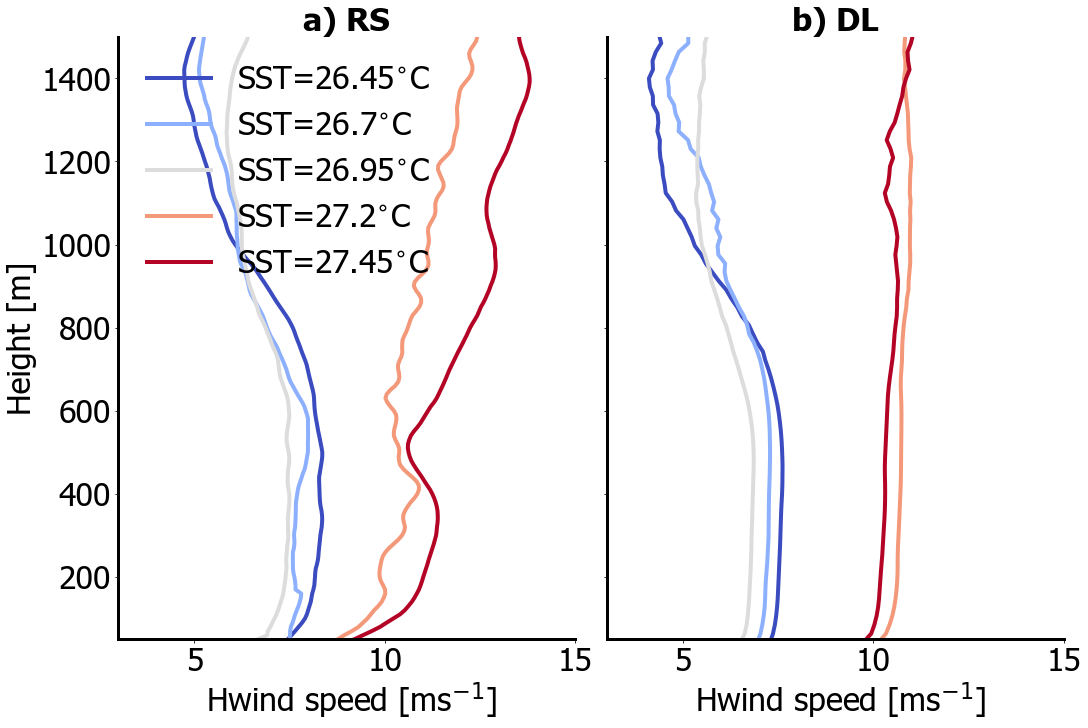

In [46]:
path_out_plots = '/Volumes/Extreme SSD/work/006_projects/001_Prec_Trade_Cycle/SST_impact_work/plots_paper/'
import matplotlib.font_manager as font_manager


dict_plot_settings = {
    'labelsizeaxes':32,
    'fontSizeTitle':32,
    'fontSizeX'    :32,
    'fontSizeY'    :32,
    'cbarAspect'   :15,
    'fontSizeCbar' :32,
    'rcparams_font':['Tahoma'],
    'savefig_dpi'  :100,
    'font_size'    :32, 
    'grid'         :True}


# plots settings defined by user at the top
labelsizeaxes   = dict_plot_settings['labelsizeaxes']
fontSizeTitle   = dict_plot_settings['fontSizeTitle']
fontSizeX       = dict_plot_settings['fontSizeX']
fontSizeY       = dict_plot_settings['fontSizeY']
cbarAspect      = dict_plot_settings['cbarAspect']
fontSizeCbar    = dict_plot_settings['fontSizeCbar']
rcParams['font.sans-serif'] = dict_plot_settings['rcparams_font']
matplotlib.rcParams['savefig.dpi'] = dict_plot_settings['savefig_dpi']
plt.rcParams.update({'font.size':dict_plot_settings['font_size']})
grid = dict_plot_settings['grid']


fig, axs = plt.subplots(1, 2, figsize=(15,10), sharey=True, constrained_layout=True)# 


labels =[]
for ind, el in enumerate(binned_sst_rs):
    labels.append('SST='+str(el))
print(labels)
font = font_manager.FontProperties(family='Tahoma',
                                   weight='light',
                                   style='normal', size=12)


#ax = fig.add_subplot(gs[0, 0])

for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[0].plot(wspd_rs[ind_sst_bin,:], height_rs, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin]+'$^{\circ}$C', linewidth=4, rasterized=True)
    
axs[0].legend(frameon=False, fontsize=fontSizeX, loc='upper left')
axs[0].set_xlabel(" Hwind speed [ms$^{-1}$]", fontsize=fontSizeX)
axs[0].set_ylabel("Height [m]", fontsize=fontSizeY)
axs[0].set_xlim(3.,15.)
axs[0].set_ylim(50.,1500.)

axs[0].spines["top"].set_visible(False)
axs[0].spines["right"].set_visible(False)
axs[0].spines["bottom"].set_linewidth(3)
axs[0].spines["left"].set_linewidth(3)
axs[0].set_title('a) RS', fontsize=32, fontweight='black')
for ind_sst_bin in range(len(binned_sst_rs)): 
    axs[1].plot(h_mean_profile[ind_sst_bin,:], DL_cold_patch.height.values, color=colors_binned_sst[ind_sst_bin], label=labels[ind_sst_bin]+'$^{\circ}$C', linewidth=4, rasterized=True)
#axs[1].legend(frameon=False, fontsize=fontSizeX, loc='lower left')
axs[1].set_xlabel(" Hwind speed [ms$^{-1}$]", fontsize=fontSizeX)
#axs[1].set_xlim(3,17.5)
axs[1].set_ylim(50.,1500.)
axs[1].set_xlim(3.,15.)

axs[1].spines["top"].set_visible(False)
axs[1].spines["right"].set_visible(False)
axs[1].spines["bottom"].set_linewidth(3)
axs[1].spines["left"].set_linewidth(3)
axs[1].set_title('b) DL', fontsize=32, fontweight='black')
fig.savefig(path_out_plots+'r1_hwind.png')

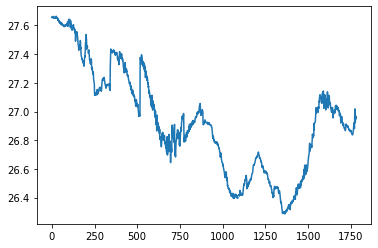

In [15]:
plt.plot(SST_interp.SST.values)

In [38]:
h_mean_profile

array([[ 3.5812122 ,  7.03520501,  7.2852856 , ...,         nan,
                nan,         nan],
       [ 4.08589895,  6.29289255,  6.94825936, ...,         nan,
                nan,         nan],
       [ 3.31111361,  5.63775755,  6.51226214, ...,         nan,
                nan,         nan],
       [ 1.53703748,  6.17842799, 10.13597334, ...,         nan,
                nan,         nan],
       [        nan,  5.81035194,  9.73428688, ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [27]:
len(SST_interp.SST.values)

1782

In [24]:
len(DL_cold_patch.height.values)

400

In [25]:
np.shape(DL_cold_patch.H_wind_speed.values)

(1782, 400)